In [117]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [118]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68', 'Mass_u68',
        'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flux_corr',
       'g_hsc_flux_corr', 'nb921_hsc_flux_corr', 'g_rcs_flux_corr'
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [119]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_filled_preprocessed.csv")

In [120]:
data.columns

Index(['Source_Name', 'Total_flux', 'Peak_flux', 'S_Code', 'EBV',
       'FUV_flux_corr', 'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr',
       'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr',
       'y_flux_corr', 'J_flux_corr', 'H_flux_corr', 'K_flux_corr',
       'Ks_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250',
       'F_SPIRE_350', 'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68',
       'Mass_u68', 'Source', 'AGN_final', 'RadioAGN_final', 'Classification',
       'Radio_excess', 'AGNfrac_af', 'AGNfrac_af_16', 'AGNfrac_cg_s_16',
       'Xray', 'Opt_spec', 'Extended_radio', 'z_rcs_flux_corr',
       'z_hsc_flux_corr', 'i_hsc_flux_corr', 'i_rcs_flux_corr', 'i_flux_corr',
       'y_hsc_flux_corr', 'r_flux_corr', 'r_hsc_flux_corr', 'r_rcs_flux_corr',
       'ch1_swire_flux_corr', 'ch2_swire_flux_corr', 'ch3_swire_flux_corr',
       'ch4_swire_flux_corr', 'ch1_servs_flu

In [121]:
data.isna().sum()

Source_Name            0
Total_flux             0
Peak_flux              0
S_Code                 0
EBV                    0
                      ..
ch2_servs_flux_corr    0
g_flux_corr            0
g_hsc_flux_corr        0
nb921_hsc_flux_corr    0
g_rcs_flux_corr        0
Length: 62, dtype: int64

In [122]:
X = data[features_num]
y = data[np.append(y_column, ['Xray', 'Opt_spec', 'Extended_radio'])]

In [123]:
le = LabelEncoder()
labels = np.unique(y[y_column].astype(str))
y[y_column] = le.fit_transform(y[y_column])

C:\Users\jespe\AppData\Local\Temp\ipykernel_14216\2925652128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y_column] = le.fit_transform(y[y_column])


In [124]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

y_train_flags = y_train[['Xray', 'Opt_spec', 'Extended_radio']]
y_test_flags = y_test[['Xray', 'Opt_spec', 'Extended_radio']]

y_train = y_train.drop(columns=['Xray', 'Opt_spec', 'Extended_radio'])
y_test = y_test.drop(columns=['Xray', 'Opt_spec', 'Extended_radio'])

In [125]:
def one_hot(df, columns):
    """
    One-hot encoding a certain column in a dataframe
    """
    one_hot = pd.get_dummies(df[columns])
    df = df.drop(columns=columns, axis = 1)
    df = df.join(one_hot)
    return df

In [126]:
# Imputing missing categorical features
imp = SimpleImputer(strategy="most_frequent")

# Standard scaling the numerical data
scaler = MinMaxScaler()

# Transforming the categorical data
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

In [127]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Random forest

In [221]:
clf = RandomForestClassifier(n_estimators=200, 
                             max_features=None,
                             n_jobs=-1, 
                             class_weight={0: 3, 1: 1000, 2: 1.5, 3: 0.5},
                             random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 3, 1: 1000, 2: 1.5, 3: 0.5},
                       max_features=None, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [195]:
cv_score = cross_val_score(clf, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [196]:
print("Cross-validated Accuracy:", round(np.mean(cv_score), 5), "±", round(np.std(cv_score), 5))

Cross-validated Accuracy: 0.83311 ± 0.01399


In [222]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8109    0.5498    0.6553      2581
quasar-like radio AGN / high-excitation radio galaxy     0.4828    0.1556    0.2353       270
                                     radio-quiet AGN     0.7609    0.5140    0.6136      1356
                                 star-forming galaxy     0.8531    0.9627    0.9046     11315

                                            accuracy                         0.8408     15522
                                           macro avg     0.7269    0.5455    0.6022     15522
                                        weighted avg     0.8316    0.8408    0.8261     15522



[]

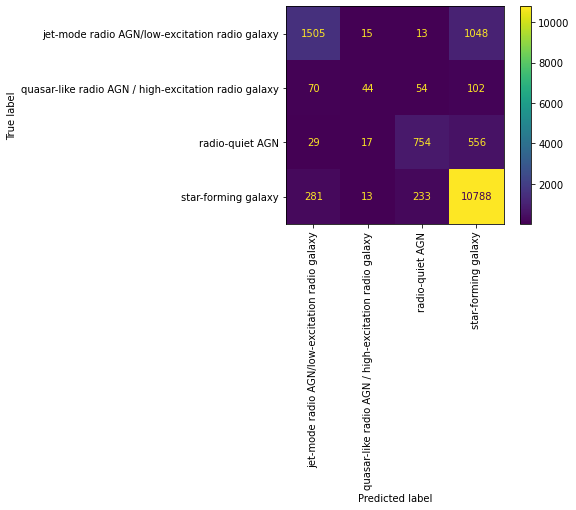

In [77]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# Lightgbm

In [303]:
import lightgbm as lgb
lightbm = lgb.LGBMClassifier(num_class=4, 
                             objective="multiclass",  
                             n_estimators=10000, 
                             class_weight="balanced",
                            early_stopping_round=50,
                            verbose=-1,
                            max_depth=8,
                            num_leaves=70,
                            min_data_in_leaf=0)

In [304]:
lightbm.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], sample_weight=classes_weights)

d:\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[1]	training's multi_logloss: 0.621214	valid_0's multi_logloss: 2.46531
[2]	training's multi_logloss: 0.54254	valid_0's multi_logloss: 2.20184
[3]	training's multi_logloss: 0.487323	valid_0's multi_logloss: 2.04417
[4]	training's multi_logloss: 0.443127	valid_0's multi_logloss: 1.92053
[5]	training's multi_logloss: 0.406148	valid_0's multi_logloss: 1.82627
[6]	training's multi_logloss: 0.375405	valid_0's multi_logloss: 1.75141
[7]	training's multi_logloss: 0.34849	valid_0's multi_logloss: 1.68196
[8]	training's multi_logloss: 0.325295	valid_0's multi_logloss: 1.62312
[9]	training's multi_logloss: 0.305011	valid_0's multi_logloss: 1.57126
[10]	training's multi_logloss: 0.286661	valid_0's multi_logloss: 1.52537
[11]	training's multi_logloss: 0.270408	valid_0's multi_logloss: 1.48559
[12]	training's multi_logloss: 0.255715	valid_0's multi_logloss: 1.45094
[13]	training's

[111]	training's multi_logloss: 0.0282929	valid_0's multi_logloss: 0.727329
[112]	training's multi_logloss: 0.0278508	valid_0's multi_logloss: 0.723878
[113]	training's multi_logloss: 0.0274589	valid_0's multi_logloss: 0.722028
[114]	training's multi_logloss: 0.0270368	valid_0's multi_logloss: 0.718741
[115]	training's multi_logloss: 0.0266404	valid_0's multi_logloss: 0.714822
[116]	training's multi_logloss: 0.0263269	valid_0's multi_logloss: 0.711649
[117]	training's multi_logloss: 0.0260426	valid_0's multi_logloss: 0.709255
[118]	training's multi_logloss: 0.0258029	valid_0's multi_logloss: 0.708832
[119]	training's multi_logloss: 0.0254505	valid_0's multi_logloss: 0.707542
[120]	training's multi_logloss: 0.0251294	valid_0's multi_logloss: 0.705074
[121]	training's multi_logloss: 0.0248019	valid_0's multi_logloss: 0.702345
[122]	training's multi_logloss: 0.0245414	valid_0's multi_logloss: 0.700488
[123]	training's multi_logloss: 0.0242265	valid_0's multi_logloss: 0.6984
[124]	training

[220]	training's multi_logloss: 0.00892004	valid_0's multi_logloss: 0.563315
[221]	training's multi_logloss: 0.00886483	valid_0's multi_logloss: 0.56275
[222]	training's multi_logloss: 0.00877667	valid_0's multi_logloss: 0.561666
[223]	training's multi_logloss: 0.00870686	valid_0's multi_logloss: 0.560984
[224]	training's multi_logloss: 0.00863085	valid_0's multi_logloss: 0.560113
[225]	training's multi_logloss: 0.00855843	valid_0's multi_logloss: 0.559733
[226]	training's multi_logloss: 0.00847138	valid_0's multi_logloss: 0.558862
[227]	training's multi_logloss: 0.00840087	valid_0's multi_logloss: 0.557947
[228]	training's multi_logloss: 0.0083054	valid_0's multi_logloss: 0.556477
[229]	training's multi_logloss: 0.00824976	valid_0's multi_logloss: 0.556061
[230]	training's multi_logloss: 0.00816767	valid_0's multi_logloss: 0.554729
[231]	training's multi_logloss: 0.00809414	valid_0's multi_logloss: 0.554027
[232]	training's multi_logloss: 0.00803385	valid_0's multi_logloss: 0.553536
[

[329]	training's multi_logloss: 0.00358413	valid_0's multi_logloss: 0.500528
[330]	training's multi_logloss: 0.0035628	valid_0's multi_logloss: 0.500324
[331]	training's multi_logloss: 0.00354269	valid_0's multi_logloss: 0.500327
[332]	training's multi_logloss: 0.00351566	valid_0's multi_logloss: 0.499934
[333]	training's multi_logloss: 0.00348314	valid_0's multi_logloss: 0.49969
[334]	training's multi_logloss: 0.00345988	valid_0's multi_logloss: 0.499308
[335]	training's multi_logloss: 0.00343417	valid_0's multi_logloss: 0.498829
[336]	training's multi_logloss: 0.00340641	valid_0's multi_logloss: 0.498503
[337]	training's multi_logloss: 0.00338044	valid_0's multi_logloss: 0.498282
[338]	training's multi_logloss: 0.00335683	valid_0's multi_logloss: 0.497859
[339]	training's multi_logloss: 0.00332659	valid_0's multi_logloss: 0.49755
[340]	training's multi_logloss: 0.00330644	valid_0's multi_logloss: 0.497311
[341]	training's multi_logloss: 0.00328187	valid_0's multi_logloss: 0.497015
[3

KeyboardInterrupt: 

In [231]:
cv_score_lgb = cross_val_score(lightbm, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [232]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_lgb), 5), "±", round(np.std(cv_score_lgb), 5))

Cross-validated Accuracy: 0.87436 ± 0.01571


In [226]:
y_pred = lightbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7767    0.8694    0.8205      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5247    0.4333    0.4746       270
                                     radio-quiet AGN     0.6689    0.8105    0.7329      1356
                                 star-forming galaxy     0.9525    0.9064    0.9289     11315

                                            accuracy                         0.8836     15522
                                           macro avg     0.7307    0.7549    0.7392     15522
                                        weighted avg     0.8911    0.8836    0.8858     15522



[]

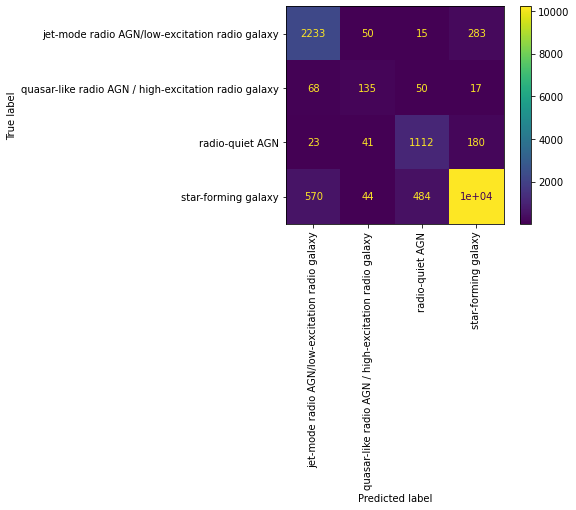

In [29]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# XGBoost

In [309]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=8, 
                      reg_alpha=0, 
                      min_child_weight=0, 
                      reg_lambda=1,
                      eta=0.1,
                      subsample=1, # 1 normally
                      colsample_bytree=1, # 1 normally
                      tree_method='hist', # exact is more precies, but this is much faster
                      eval_metric=['merror'],
                      objective='multi:softprob',
                      n_estimators=8000,
                      )

In [310]:
bst = model.fit(X_train, y_train, 
                eval_set=[(X_test, y_test), (X_train, y_train)], 
                early_stopping_rounds=200,
                verbose=True, 
                sample_weight=classes_weights
               ) # Maybe remove weight

[0]	validation_0-merror:0.21054	validation_1-merror:0.19229
[1]	validation_0-merror:0.20352	validation_1-merror:0.18468
[2]	validation_0-merror:0.19875	validation_1-merror:0.17830
[3]	validation_0-merror:0.19521	validation_1-merror:0.17318
[4]	validation_0-merror:0.19289	validation_1-merror:0.16936
[5]	validation_0-merror:0.19147	validation_1-merror:0.16580
[6]	validation_0-merror:0.18773	validation_1-merror:0.16393
[7]	validation_0-merror:0.18767	validation_1-merror:0.16229
[8]	validation_0-merror:0.18522	validation_1-merror:0.16000
[9]	validation_0-merror:0.18284	validation_1-merror:0.15846
[10]	validation_0-merror:0.18252	validation_1-merror:0.15530
[11]	validation_0-merror:0.18226	validation_1-merror:0.15354
[12]	validation_0-merror:0.18026	validation_1-merror:0.15258
[13]	validation_0-merror:0.17962	validation_1-merror:0.15106
[14]	validation_0-merror:0.17936	validation_1-merror:0.15026
[15]	validation_0-merror:0.17659	validation_1-merror:0.14841
[16]	validation_0-merror:0.17569	v

[134]	validation_0-merror:0.12363	validation_1-merror:0.04441
[135]	validation_0-merror:0.12402	validation_1-merror:0.04391
[136]	validation_0-merror:0.12382	validation_1-merror:0.04341
[137]	validation_0-merror:0.12337	validation_1-merror:0.04302
[138]	validation_0-merror:0.12350	validation_1-merror:0.04270
[139]	validation_0-merror:0.12369	validation_1-merror:0.04202
[140]	validation_0-merror:0.12305	validation_1-merror:0.04160
[141]	validation_0-merror:0.12286	validation_1-merror:0.04138
[142]	validation_0-merror:0.12215	validation_1-merror:0.04099
[143]	validation_0-merror:0.12208	validation_1-merror:0.04027
[144]	validation_0-merror:0.12183	validation_1-merror:0.04017
[145]	validation_0-merror:0.12189	validation_1-merror:0.03969
[146]	validation_0-merror:0.12138	validation_1-merror:0.03904
[147]	validation_0-merror:0.12170	validation_1-merror:0.03857
[148]	validation_0-merror:0.12131	validation_1-merror:0.03816
[149]	validation_0-merror:0.12131	validation_1-merror:0.03795
[150]	va

[267]	validation_0-merror:0.10740	validation_1-merror:0.00747
[268]	validation_0-merror:0.10746	validation_1-merror:0.00741
[269]	validation_0-merror:0.10740	validation_1-merror:0.00713
[270]	validation_0-merror:0.10688	validation_1-merror:0.00696
[271]	validation_0-merror:0.10675	validation_1-merror:0.00678
[272]	validation_0-merror:0.10656	validation_1-merror:0.00665
[273]	validation_0-merror:0.10669	validation_1-merror:0.00659
[274]	validation_0-merror:0.10630	validation_1-merror:0.00651
[275]	validation_0-merror:0.10624	validation_1-merror:0.00641
[276]	validation_0-merror:0.10649	validation_1-merror:0.00636
[277]	validation_0-merror:0.10656	validation_1-merror:0.00626
[278]	validation_0-merror:0.10617	validation_1-merror:0.00617
[279]	validation_0-merror:0.10662	validation_1-merror:0.00609
[280]	validation_0-merror:0.10643	validation_1-merror:0.00596
[281]	validation_0-merror:0.10649	validation_1-merror:0.00594
[282]	validation_0-merror:0.10617	validation_1-merror:0.00586
[283]	va

[400]	validation_0-merror:0.10379	validation_1-merror:0.00034
[401]	validation_0-merror:0.10347	validation_1-merror:0.00034
[402]	validation_0-merror:0.10353	validation_1-merror:0.00034
[403]	validation_0-merror:0.10366	validation_1-merror:0.00034
[404]	validation_0-merror:0.10347	validation_1-merror:0.00032
[405]	validation_0-merror:0.10340	validation_1-merror:0.00034
[406]	validation_0-merror:0.10340	validation_1-merror:0.00034
[407]	validation_0-merror:0.10327	validation_1-merror:0.00029
[408]	validation_0-merror:0.10347	validation_1-merror:0.00027
[409]	validation_0-merror:0.10372	validation_1-merror:0.00027
[410]	validation_0-merror:0.10372	validation_1-merror:0.00024
[411]	validation_0-merror:0.10392	validation_1-merror:0.00021
[412]	validation_0-merror:0.10366	validation_1-merror:0.00022
[413]	validation_0-merror:0.10366	validation_1-merror:0.00022
[414]	validation_0-merror:0.10353	validation_1-merror:0.00021
[415]	validation_0-merror:0.10340	validation_1-merror:0.00018
[416]	va

[533]	validation_0-merror:0.10095	validation_1-merror:0.00000
[534]	validation_0-merror:0.10134	validation_1-merror:0.00000
[535]	validation_0-merror:0.10134	validation_1-merror:0.00000
[536]	validation_0-merror:0.10121	validation_1-merror:0.00000
[537]	validation_0-merror:0.10134	validation_1-merror:0.00000
[538]	validation_0-merror:0.10128	validation_1-merror:0.00000
[539]	validation_0-merror:0.10134	validation_1-merror:0.00000
[540]	validation_0-merror:0.10128	validation_1-merror:0.00000
[541]	validation_0-merror:0.10121	validation_1-merror:0.00000
[542]	validation_0-merror:0.10121	validation_1-merror:0.00000
[543]	validation_0-merror:0.10121	validation_1-merror:0.00000
[544]	validation_0-merror:0.10102	validation_1-merror:0.00000
[545]	validation_0-merror:0.10095	validation_1-merror:0.00000
[546]	validation_0-merror:0.10063	validation_1-merror:0.00000
[547]	validation_0-merror:0.10095	validation_1-merror:0.00000
[548]	validation_0-merror:0.10115	validation_1-merror:0.00000
[549]	va

KeyboardInterrupt: 

In [23]:
bst.save_model('combined_xgboost.json')

[]

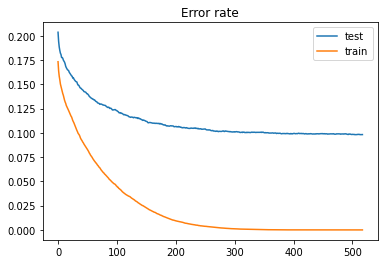

In [297]:
errors_test = bst.evals_result()['validation_0']['merror']
plt.plot(range(len(errors_test)), errors_test, label='test')
errors_train = bst.evals_result()['validation_1']['merror']
plt.plot(range(len(errors_train)), errors_train, label='train')
plt.title('Error rate')
plt.legend()
plt.plot()

[]

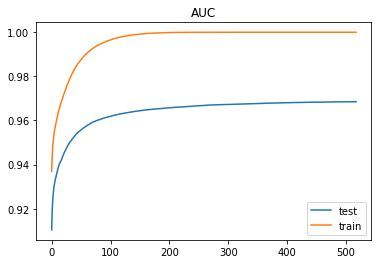

In [298]:
errors_test = bst.evals_result()['validation_0']['auc']
plt.plot(range(len(errors_test)), errors_test, label='test')
errors_train = bst.evals_result()['validation_1']['auc']
plt.plot(range(len(errors_train)), errors_train, label='train')
plt.title('AUC')
plt.legend()
plt.plot()

In [139]:
cross_val_model = XGBClassifier(use_label_encoder=False, 
                      max_depth=7, 
                      reg_alpha=0, 
                      min_child_weight=0, 
                      reg_lambda=1,
                      eta=0.1,
                      subsample=1, # 1 normally
                      colsample_bytree=1, # 1 normally
                      tree_method='hist', # exact is more precies, but this is much faster
                      eval_metric=['merror', 'auc'],
                      objective='multi:softprob',
                      n_estimators=1000)

In [140]:
cv_score_xgb = cross_val_score(cross_val_model, X_train, y_train, cv=8, n_jobs=-1, scoring="accuracy")

KeyboardInterrupt: 

In [ ]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

In [299]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8342    0.8346    0.8344      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5829    0.4037    0.4770       270
                                     radio-quiet AGN     0.7321    0.7861    0.7582      1356
                                 star-forming galaxy     0.9414    0.9399    0.9407     11315

                                            accuracy                         0.8996     15522
                                           macro avg     0.7727    0.7411    0.7526     15522
                                        weighted avg     0.8991    0.8996    0.8990     15522



[]

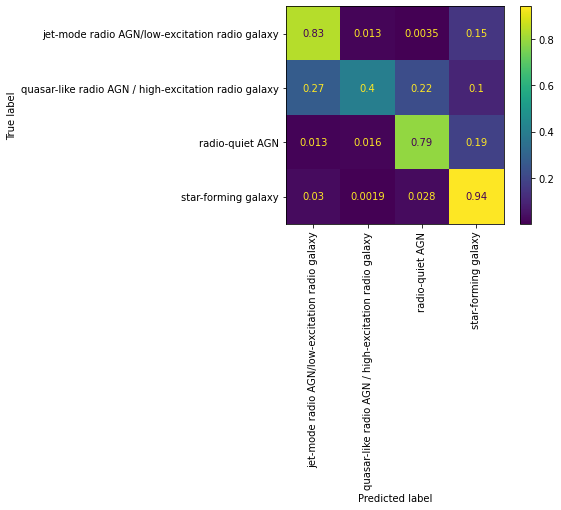

In [300]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

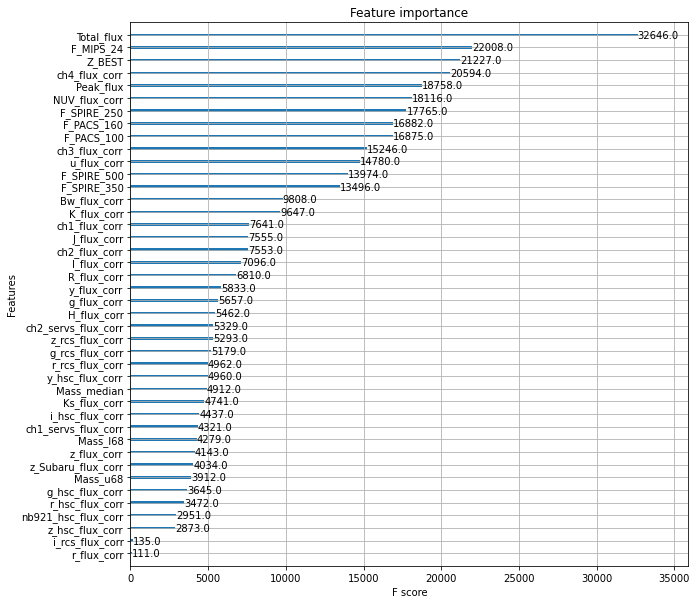

In [116]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

## Flag marking

In [189]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=['Prediction'])

d:\python\python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [228]:
Xray_all = []
opt_spec_all = []
ext_radio_all = []
for j in range(4):
    for i in range(4):
        # Finding pandas dataframes for the squares in the confusion matrix
        cm_square = y_pred[(y_test['Classification']==j) & (y_pred['Prediction']==i)]
        flags = y_test_flags.loc[cm_square.index]

        # Finding frequencies of flags
        Xray_freq = sum(flags['Xray'])/len(flags['Xray'])
        opt_spec_freq = sum(flags['Opt_spec'])/len(flags['Opt_spec'])
        ext_radio_freq = sum(flags['Extended_radio'])/len(flags['Extended_radio'])

        Xray_all.append(Xray_freq)
        opt_spec_all.append(opt_spec_freq)
        ext_radio_all.append(ext_radio_freq)

In [263]:
ext_radio_all[12:16]

[0.0, 0.0, 0.0, 0.0]

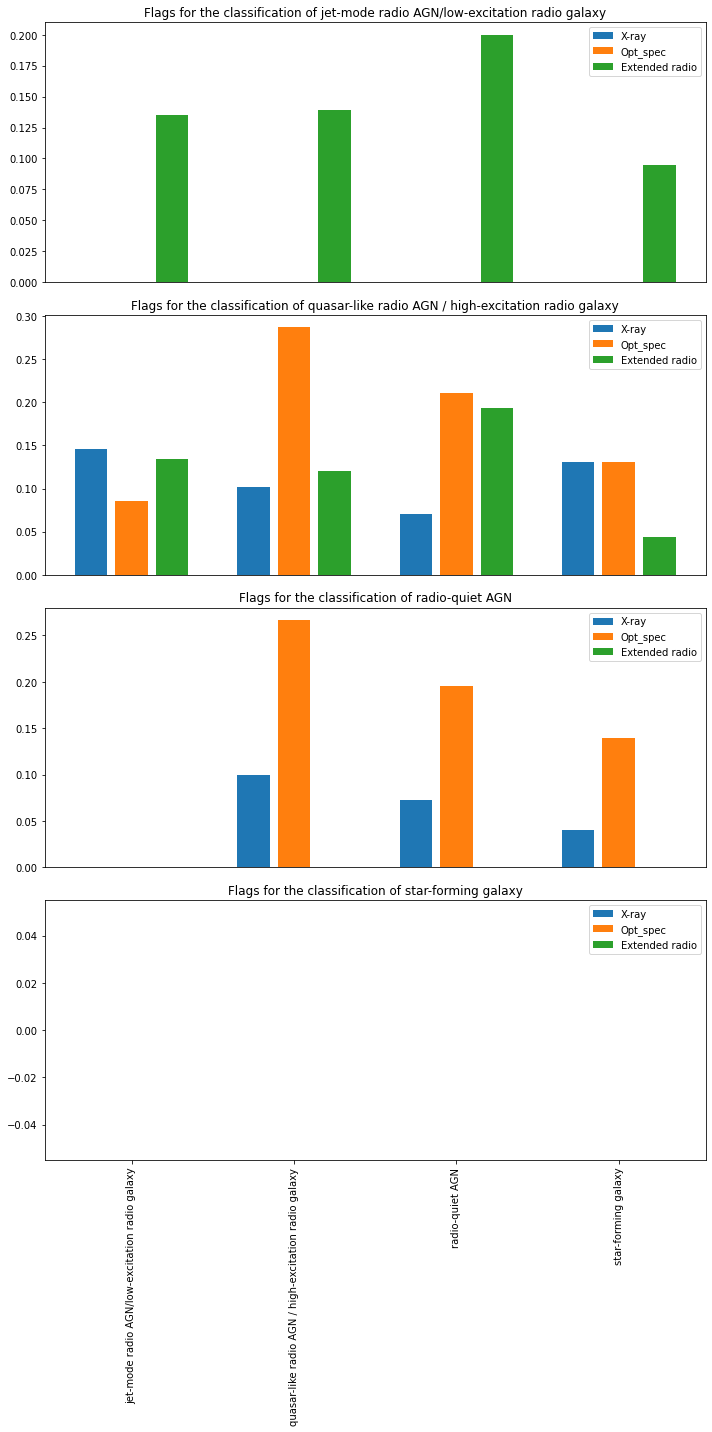

In [261]:
x = np.arange(0,16,4)
fig, axes = plt.subplots(4, 1, figsize=(10,20))
for i, ax in enumerate(axes):
    i0 = i*4
    i1 = (i+1)*4
    
    ax.bar(x, Xray_all[i0:i1], label='X-ray')
    # For setting the tick labels
    if i==3:
        ax.bar(x+1, opt_spec_all[i0:i1], label='Opt_spec', tick_label=labels)
    else:
        ax.bar(x+1, opt_spec_all[i0:i1], label='Opt_spec')
        ax.get_xaxis().set_visible(False)
    ax.bar(x+2, ext_radio_all[i0:i1], label='Extended radio')
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_title(f'Flags for the classification of {labels[i]}')
    ax.legend()
plt.tight_layout()
fig.savefig('Flags.png')

# Adaboost

In [197]:
from sklearn.ensemble import AdaBoostClassifier

In [207]:
ada = AdaBoostClassifier(n_estimators=50, learning_rate=0.3, random_state=42)

In [208]:
ada.fit(X_train, y_train, sample_weight=classes_weights)

AdaBoostClassifier(learning_rate=0.3, random_state=42)

In [209]:
y_pred = ada.predict(X_train)
print(classification_report(y_train, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.4535    0.5478    0.4962     10186
quasar-like radio AGN / high-excitation radio galaxy     0.1239    0.4896    0.1978      1062
                                     radio-quiet AGN     0.4399    0.6761    0.5330      5514
                                 star-forming galaxy     0.8776    0.7186    0.7902     45325

                                            accuracy                         0.6829     62087
                                           macro avg     0.4738    0.6080    0.5043     62087
                                        weighted avg     0.7563    0.6829    0.7090     62087



In [210]:
y_pred = ada.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.4391    0.5339    0.4819      2581
quasar-like radio AGN / high-excitation radio galaxy     0.1155    0.4667    0.1852       270
                                     radio-quiet AGN     0.4225    0.6652    0.5168      1356
                                 star-forming galaxy     0.8730    0.7066    0.7810     11315

                                            accuracy                         0.6701     15522
                                           macro avg     0.4625    0.5931    0.4912     15522
                                        weighted avg     0.7483    0.6701    0.6978     15522



# DNN

In [28]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dic = {i:class_weight[i] for i in range(4)}

In [70]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4),
    ]
)

In [71]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="Adam",
    metrics=["accuracy"],
)

In [72]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
)

In [74]:
model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=1000,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),
    class_weight=class_weight_dic,
)

Epoch 1/1000
1941/1941 [==============================] - 5s 2ms/step - loss: 1.2237 - accuracy: 0.5100 - val_loss: 1.1177 - val_accuracy: 0.6102
Epoch 2/1000
1941/1941 [==============================] - 5s 2ms/step - loss: 1.1852 - accuracy: 0.5153 - val_loss: 1.1890 - val_accuracy: 0.2875
Epoch 3/1000
1047/1941 [===============>..............] - ETA: 2s - loss: 1.1610 - accuracy: 0.5283

KeyboardInterrupt: 

# SVM

In [431]:
from sklearn.svm import SVC

In [429]:
new_y_train = y_train
new_y_train[new_y_train['Classification']>1] = 0

new_y_test = y_test
new_y_test[new_y_test['Classification']>1] = 0

In [439]:
clf = SVC(class_weight='balanced')
clf.fit(X_train, new_y_train.values.flatten())

SVC(class_weight='balanced')

In [440]:
y_pred = clf.predict(X_test)
print(classification_report(new_y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9890    0.5771    0.7289     15252
           1     0.0260    0.6370    0.0499       270

    accuracy                         0.5781     15522
   macro avg     0.5075    0.6071    0.3894     15522
weighted avg     0.9722    0.5781    0.7171     15522



[]

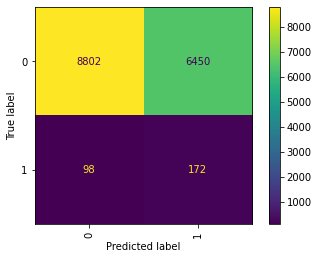

In [441]:
cm = confusion_matrix(new_y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()